In [1]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
import scipy.optimize as sp
from scipy.integrate import RK45
from pyqubo import Spin, Array
import neal

# Function definitions

In [49]:
# IBM Q statevector simulator

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s).
provider = IBMQ.load_account()

def add_IQP_gate(circ, q1,q2, th):
    """Adds an RZZGate to the circuit."""
    circ.cnot(q1,q2)
    circ.rz(th,q2)
    circ.cnot(q1,q2)
    
def get_prob_IBM(x,n_qubits,configs):
    """Returns probabilities of sampling configurations in configs list
    for an IQP circuit defined by parameters x."""
    N = n_qubits
    phi = x[:N]
    th_s = x[N:2*N]
    th_d = x[2*N:]
    
    circ = QuantumCircuit(N)

    for i in range(N):
        circ.h(N-i-1)
        circ.rz(th_s[i],N-i-1)

    for i in range(N):
        for j in range(i):
            add_IQP_gate(circ,N-i-1,N-j-1,th_d[int(pair_ind[i,j])])

    for i in range(N):
        circ.rx(phi[i],N-i-1)
        
    simulator = Aer.get_backend('statevector_simulator')
    job_statevector = simulator.run(circ)
    statevector = job_statevector.result().get_statevector()
    probs = []
    for s in configs:
        n = int(s,2)
        probs.append(abs(statevector[n])**2)
    return probs

def sample_IQP_IBM(x,n_qubits,num_samples,ground_config = 0):
    """Returns samples from the IQP defined by parameters x, 
    as well as the cumulative probability in list ground_config."""
    N = n_qubits
    phi = x[:N]
    th_s = x[N:2*N]
    th_d = x[2*N:]
    
    circ = QuantumCircuit(N)

    for i in range(N):
        circ.h(N-i-1)
        circ.rz(th_s[i],N-i-1)

    for i in range(N):
        for j in range(i):
            add_IQP_gate(circ,N-i-1,N-j-1,th_d[int(pair_ind[i,j])])

    for i in range(N):
        circ.rx(phi[i],N-i-1)
    
    circ.snapshot(label='my_sv',snapshot_type='statevector')
    circ.measure_all()
    simulator = Aer.get_backend('qasm_simulator')
    result = simulator.run(circ,shots=num_samples).result()
    statevector = result.data()['snapshots']['statevector']['my_sv'][0]
    counts = result.get_counts()
    samples_binary = []
    for sample in counts.keys():
        for i in range(counts[sample]):
            samples_binary.append(sample)
    if ground_config:
        ground_prob = 0
        for conf in ground_config:
            ground_prob += abs(statevector[int(conf,2)])**2
        return samples_binary, ground_prob
    else:
        return samples_binary

ibmqfactory.load_account:WARNING:2022-10-10 13:33:33,845: Credentials are already in use. The existing account in the session will be replaced.


In [50]:
# Auxiliary functions

def mirror(s):
    """Return the configuration corresponding to flipping all spins."""
    sol_mirror = bin(2**N-1-int(s,2))[2:]
    sol_mirror = '0'*(N-len(sol_mirror))+sol_mirror
    return sol_mirror

def get_SK_hamilt(N, seed, bias):
    """Returns a randomly generated Sherrington-Kirkpatrick Hamiltonian. 
    A biasing global field may be applied."""
    np.random.seed(seed = seed)
    h = bias*np.ones(N)
    g = 1/np.sqrt(N)*np.random.normal(size = [N,N])
    for i in range(N):
        for j in range(i):
            g[i,j] = g[j,i]
    for i in range(N):
        g[i,i] = 0
    return h,g

def energy_from_config(config,h,g):
    """Returns the energy of a configuration."""
    N = len(h)
    s = [int(i) for i in config]
    energy = 0
    for i in range(N):
        energy += h[i]*(1-2*s[i])
    for i in range(N):
        for j in range(i):
            energy+= g[i,j]*(1-2*s[i])*(1-2*s[j])
    return energy

In [51]:
# QAOA optimization functions

def QAOA_params(beta,gamma,h,g):
    """Returns the IQP parameters x corresponding to the
    reduced QAOA parameters of some Hamiltonian."""
    N = len(h)
    phi = 2*beta*np.ones(N)
    theta_s = 1e-10*np.ones(N)
    theta_d_vec = np.zeros(np.int32(N*(N-1)/2))
    for i in range(N):
        theta_s[i] += 2*h[0]*gamma
    for i in range(N):
        for j in range(i):
            theta_d_vec[np.int32(pair_ind[i,j])] = 2*g[i,j]*gamma
    x = np.hstack((phi,theta_s,theta_d_vec))
    return x

In [52]:
# Wrappers

def energy_wrapper_QAOA(x_QAOA):
    """Returns the energy of a point on the QAOA submanifold."""
    beta = x_QAOA[0]
    gamma = x_QAOA[1]
    x = QAOA_params(beta,gamma,h,g)
    E, jac = hamilt_energy(h,g,x)
    return E

def RK45_energy_wrapper(t,x):
    """Returns the gradient of the energy landscape at parameters x."""
    energy, jac = hamilt_energy(h,g,x)
    return -jac

def RK45_energy_wrapper_v(t,y):
    """Returns the Gram matrix adjusted gradient, as required by the VarQITE protocol."""
    energy, jac = hamilt_energy(h,g,y)
    inv_A = inv_Gram_matrix(y,N)
    return -1/4*inv_A.dot(jac)

In [53]:
# PyQubo simulated annealing solver

def get_exact_sol_pyqubo(h,g):
    """Use pyqubo to find the ground state of Hamiltonian defined by (h,g) pair."""
    N = len(h)
    x_ = Array.create('x', shape=N, vartype='BINARY')
    H_qubo = 0
    for i in range(N):
        H_qubo += h[i]*(1-2*x_[i])
    for i in range(N):
        for j in range(i):
            H_qubo+= g[i,j]*(1-2*x_[i])*(1-2*x_[j])
    model = H_qubo.compile()
    bqm = model.to_bqm()
    sa = neal.SimulatedAnnealingSampler()
    sampleset = sa.sample(bqm, num_reads=1000)
    decoded_samples = model.decode_sampleset(sampleset)
    best_sample = min(decoded_samples, key=lambda x: x.energy)
    sol = ''
    for i in range(N):
        s = best_sample.sample['x['+ str(i)+']']
        sol = sol+str(s)
    return sol, best_sample.energy

In [54]:
# Core functions for traversing the variational landscape

pair_ind = np.zeros([1000,1000]) # Auxiliary matrix for array to linear format conversion.
index = 0
for i in range(1000):
    for j in range(i):
        pair_ind[j,i] = index
        index += 1
pair_ind = pair_ind+pair_ind.T

@njit
def hamilt_energy(h,g,x):
    """Returns the energy and gradient of an IQP state with parameters x."""
    E = 0
    M = len(h)
    num_params = int(M*(M+3)/2)
    phi = x[:M]
    th_x = x[M:2*M]
    th_xy = x[2*M:]
    jac = np.zeros(num_params)
    Sin_phi = np.sin(x[:M])
    Cos_phi = np.cos(x[:M])
    Sin_th_x = np.sin(x[M:2*M])
    Cos_th_x = np.cos(x[M:2*M])
    Sin_th_xy = np.sin(x[2*M:])
    Cos_th_xy = np.cos(x[2*M:])
    
    # Single term expectation values
    for i in range(M):
        Z_exp = Sin_th_x[i]
        Z_grad = np.zeros(num_params)
        for j in range(M):
            if i != j:
                Z_exp *= Cos_th_xy[int(pair_ind[i,j])]
        Z_grad[i] += Cos_phi[i]*Z_exp
        Z_grad[M+i] += Sin_phi[i]*Z_exp*Cos_th_x[i]/Sin_th_x[i]
        for j in range(M):
            if i != j:
                Z_grad[2*M+int(pair_ind[i,j])] += -Z_exp*Sin_phi[i]*Sin_th_xy[int(pair_ind[i,j])]/Cos_th_xy[int(pair_ind[i,j])]
        E += h[i]*Sin_phi[i]*Z_exp
        jac += h[i]*Z_grad
    
    # Doubles term expectation values
    for i in range(M):
        for j in range(i):
            # ZX contributions
            Z1X2 = Cos_phi[i]*Sin_phi[j]*Cos_th_x[j]*Sin_th_xy[int(pair_ind[i,j])]
            Z1X2_grad = np.zeros(num_params)
            for k in range(M):
                if k != i and k!=j:
                    Z1X2 *= Cos_th_xy[int(pair_ind[j,k])]
            Z1X2_grad[i] += -Z1X2*Sin_phi[i]/Cos_phi[i]
            Z1X2_grad[j] += Z1X2*Cos_phi[j]/Sin_phi[j]
            Z1X2_grad[M+j] += -Z1X2*Sin_th_x[j]/Cos_th_x[j]
            Z1X2_grad[2*M+int(pair_ind[i,j])] += Z1X2*Cos_th_xy[int(pair_ind[i,j])]/Sin_th_xy[int(pair_ind[i,j])]
            for k in range(M):
                if k != i and k!=j:
                    Z1X2_grad[2*M+int(pair_ind[k,j])] += -Z1X2*Sin_th_xy[int(pair_ind[k,j])]/Cos_th_xy[int(pair_ind[k,j])]
            E += g[i,j]*Z1X2
            jac += g[i,j]*Z1X2_grad
            
            Z2X1 = Cos_phi[j]*Sin_phi[i]*Cos_th_x[i]*Sin_th_xy[int(pair_ind[i,j])]
            Z2X1_grad = np.zeros(num_params)
            for k in range(M):
                if k != i and k!=j:
                    Z2X1 *= Cos_th_xy[int(pair_ind[i,k])]
            Z2X1_grad[j] += -Z2X1*Sin_phi[j]/Cos_phi[j]
            Z2X1_grad[i] += Z2X1*Cos_phi[i]/Sin_phi[i]
            Z2X1_grad[M+i] += -Z2X1*Sin_th_x[i]/Cos_th_x[i]
            Z2X1_grad[2*M+int(pair_ind[i,j])] += Z2X1*Cos_th_xy[int(pair_ind[i,j])]/Sin_th_xy[int(pair_ind[i,j])]
            for k in range(M):
                if k != i and k!=j:
                    Z2X1_grad[2*M+int(pair_ind[i,k])] += -Z2X1*Sin_th_xy[int(pair_ind[i,k])]/Cos_th_xy[int(pair_ind[i,k])]
            E += g[i,j]*Z2X1
            jac += g[i,j]*Z2X1_grad
            
            # XX contribution
            X1X2_plus = Sin_phi[i]*Sin_phi[j]*np.cos(th_x[i]+th_x[j])
            X1X2_plus_grad = np.zeros(num_params)
            X1X2_minus = Sin_phi[i]*Sin_phi[j]*np.cos(th_x[i]-th_x[j])
            X1X2_minus_grad = np.zeros(num_params)
            for k in range(M):
                if k != i and k!=j:
                    X1X2_minus *= np.cos(th_xy[int(pair_ind[i,k])]-th_xy[int(pair_ind[k,j])])
            for k in range(M):
                if k != i and k!=j:
                    X1X2_plus *= np.cos(th_xy[int(pair_ind[i,k])]+th_xy[int(pair_ind[k,j])])
            X1X2_plus_grad[i] += X1X2_plus*Cos_phi[i]/Sin_phi[i]
            X1X2_minus_grad[i] += X1X2_minus*Cos_phi[i]/Sin_phi[i]
            X1X2_plus_grad[j] += X1X2_plus*Cos_phi[j]/Sin_phi[j]
            X1X2_minus_grad[j] += X1X2_minus*Cos_phi[j]/Sin_phi[j]
            X1X2_plus_grad[i+M] += -X1X2_plus*np.sin(th_x[i]+th_x[j])/np.cos(th_x[i]+th_x[j])
            X1X2_minus_grad[i+M] += -X1X2_minus*np.sin(th_x[i]-th_x[j])/np.cos(th_x[i]-th_x[j])
            X1X2_plus_grad[j+M] += -X1X2_plus*np.sin(th_x[i]+th_x[j])/np.cos(th_x[i]+th_x[j])
            X1X2_minus_grad[j+M] += X1X2_minus*np.sin(th_x[i]-th_x[j])/np.cos(th_x[i]-th_x[j])
            for k in range(M):
                if k != i and k!=j:
                    X1X2_plus_grad[2*M+int(pair_ind[i,k])] += -X1X2_plus*np.sin(th_xy[int(pair_ind[i,k])]+th_xy[int(pair_ind[k,j])])/np.cos(th_xy[int(pair_ind[i,k])]+th_xy[int(pair_ind[k,j])])
                    X1X2_plus_grad[2*M+int(pair_ind[j,k])] += -X1X2_plus*np.sin(th_xy[int(pair_ind[i,k])]+th_xy[int(pair_ind[k,j])])/np.cos(th_xy[int(pair_ind[i,k])]+th_xy[int(pair_ind[k,j])])
                    X1X2_minus_grad[2*M+int(pair_ind[i,k])] += -X1X2_minus*np.sin(th_xy[int(pair_ind[i,k])]-th_xy[int(pair_ind[k,j])])/np.cos(th_xy[int(pair_ind[i,k])]-th_xy[int(pair_ind[k,j])])
                    X1X2_minus_grad[2*M+int(pair_ind[j,k])] += X1X2_minus*np.sin(th_xy[int(pair_ind[i,k])]-th_xy[int(pair_ind[k,j])])/np.cos(th_xy[int(pair_ind[i,k])]-th_xy[int(pair_ind[k,j])])
            E += -g[i,j]*(X1X2_plus-X1X2_minus)/2
            jac += -g[i,j]*(X1X2_plus_grad-X1X2_minus_grad)/2
    return E, jac


@njit
def inv_Gram_matrix(x,N):
    """Returns the inverse of the Gram matrix for an IQP with parameters x."""
    phi = x[:N]
    th_x = x[N:2*N]
    th_xy = x[2*N:]
    
    A_thth = 1/4*np.eye(int(N*(N+1)/2))
    A_thphi = np.zeros((int(N*(N+1)/2),N), dtype = np.float64)
    A_phiphi = np.zeros((N,N))
    
    # Compute phiphi part
    for i in range(N):
        A_phiphi[i,i] = 1/4
        for j in range(i):
            A_plus = np.cos(th_x[i]+th_x[j])
            A_minus = np.cos(th_x[i]-th_x[j])
            for k in range(N):
                if k != i and k!=j:
                    A_plus *= np.cos(th_xy[int(pair_ind[j,k])]+th_xy[int(pair_ind[i,k])])
                    A_minus *= np.cos(th_xy[int(pair_ind[j,k])]-th_xy[int(pair_ind[i,k])])
            A_phiphi[i,j] = 1/8*(A_plus+A_minus)
            A_phiphi[j,i] = A_phiphi[i,j]
    
    # Compute thphi part
    # Singles
    for i in range(N):
        for k in range(N):
            if i != k:
                A = -1/4*np.sin(th_x[k])*np.sin(th_xy[int(pair_ind[i,k])])
                for l in range(N):
                    if l != i and l != k:
                        A *= np.cos(th_xy[int(pair_ind[l,k])])
                A_thphi[i,k] = A
    # Doubles
    for i in range(N):
        for j in range(i):
            for k in range(N):
                if k != i and k!= j:
                    A = -1/4*np.cos(th_x[k])*np.sin(th_xy[int(pair_ind[i,k])])*np.sin(th_xy[int(pair_ind[j,k])])
                    for l in range(N):
                        if l != i and l!= j and l != k:
                            A *= np.cos(th_xy[int(pair_ind[l,k])])
                    A_thphi[N+int(pair_ind[i,j])] = A
                    
    A_R_top = np.hstack((A_phiphi,A_thphi.T))
    A_R_down = np.hstack((A_thphi,A_thth))
    A_R = np.vstack((A_R_top,A_R_down))
    A_R = np.linalg.inv(A_R)
    return A_R

# Example usage

In [55]:
# Construct SK Hamiltonian coupling matrix
seed = 1673
bias = 0
N = 24
h,g = get_SK_hamilt(N,seed,bias)
sol, min_energy = get_exact_sol_pyqubo(h,g) # Get solution and minimum energy
sol_max, max_energy = get_exact_sol_pyqubo(-h,-g) # Get maximum energy, optional
max_energy = - max_energy
sol_mirror = mirror(sol)

print('Minimum energy found by annealer: ', min_energy)
print('Solution found: ', sol)

Minimum energy found by annealer:  -17.175529196064744
Solution found:  000010110010110011001010


In [56]:
# Run QAOA optimization

x_QAOA_0 = [1e-2,1e-2]
res = sp.minimize(energy_wrapper_QAOA, x_QAOA_0, tol = 1e-5)

print('QAOA optimization result: ')
print(res)

QAOA optimization result: 
      fun: -7.078235968337163
 hess_inv: array([[8.38716247e-03, 4.18121543e-05],
       [4.18121543e-05, 1.78911685e-02]])
      jac: array([1.49011612e-06, 3.87430191e-06])
  message: 'Optimization terminated successfully.'
     nfev: 81
      nit: 9
     njev: 27
   status: 0
  success: True
        x: array([ 0.38138251, -0.49708593])


 Percentage done:  99.37 % 85.7 %

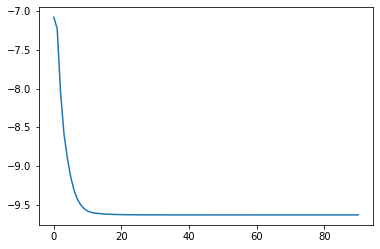

In [57]:
# Solve VarQITE equation with RK45 method

beta, gamma = res['x']
x_0 = QAOA_params(beta,gamma,h,g)

energy, jac = hamilt_energy(h,g,x_0)
t_0 = 0
t_bound = 100
x_hist = []
energy_hist = []
x_hist.append(x_0)
energy_hist.append(energy)

# Choose between wrappers:  -RK45_energy_wrapper - simple gradient
#                           -RK45_energy_wrapper_v - VarQITE adjusted gradient
resultRK45 = RK45(RK45_energy_wrapper, t_0, x_0, t_bound)

# Evolve parameters of IQP using Runge-Kutta method
while resultRK45.status == 'running':
    print('\r','Percentage done: ',round(resultRK45.t/t_bound*100,2), '%',end='')
    resultRK45.step()
    x = resultRK45.y
    x_hist.append(x)
    energy, jac = hamilt_energy(h,g,x)
    energy_hist.append(energy)
    
# Plot the energy history
plt.plot(energy_hist)
plt.show()

Best sample found:  111101001101001100110101
Best energy found:  -17.175529196064737
Is this the true ground state?: Yes
Probability of sampling true ground state:  2.1692963511502996 %


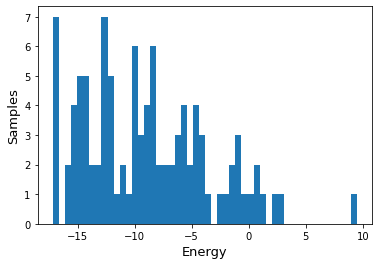

In [59]:
# Sample the IQP using Qiskit

opt_pos = -1 # Select the position where sampling is performed (0 for optimal QAOA, -1 for final IQP state)
num_samples = 100

samples_IQP , prob_ground_IQP = sample_IQP_IBM(x_hist[opt_pos],N,num_samples,ground_config = [sol,sol_mirror])
energies = [energy_from_config(con,h,g) for con in samples_IQP]

best_sample = samples_IQP[np.argmin(energies)]
print('Best sample found: ',best_sample)
print('Best energy found: ', energy_from_config(best_sample,h,g))
if best_sample == sol or best_sample == sol_mirror:
    print('Is this the true ground state?: Yes')
else:
    print('Is this the true ground state: No')
    print('Approximation ratio is: ', (max_energy-min(energies))/(max_energy-min_energy))
print('Probability of sampling true ground state: ',prob_ground_IQP*100, '%')
plt.hist(energies,bins = 50)
plt.ylabel('Samples',size = 13)
plt.xlabel('Energy',size=13)
plt.show()